In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
from scipy import ndimage
import coop_setup_funcs as csf
import warnings
from astropy.visualization import quantity_support
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
import healpy as hp

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st

In [2]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
desmask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"

0.19985555905328484 redshift 0.3565167560560754 redshift
0.3565167560560754 redshift 0.5289988643902372 redshift
0.5289988643902372 redshift 0.7215854982816572 redshift
0.7215854982816572 redshift 0.9396687416637612 redshift


In [3]:
# desmask = hp.read_map(desmask)
# hp.mollview(desmask)
# hp.cartview(desmask, lonra=[45,50], latra=[-45,-40])

In [33]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24


In [34]:
binsize=8 #Mpc

Number exceeding:  242


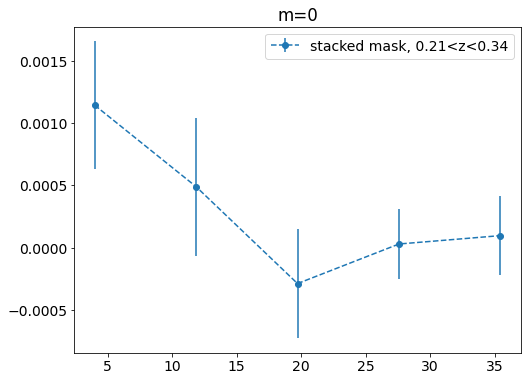

24 24


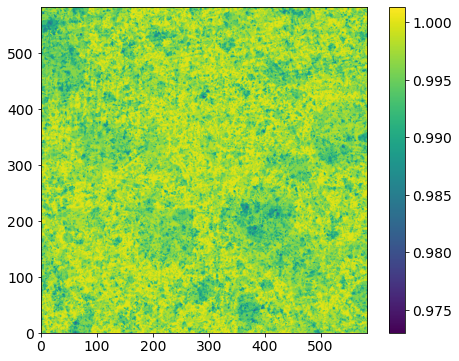

Number exceeding:  901


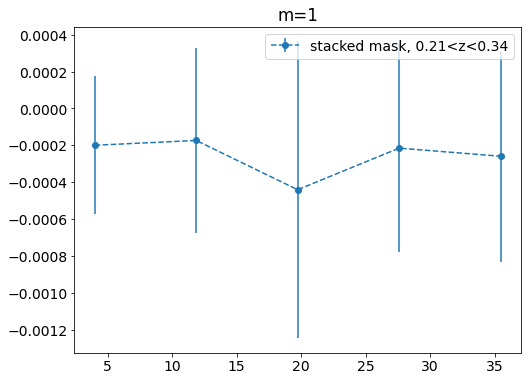

24 24


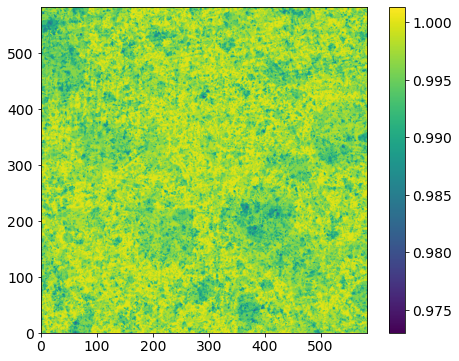

Number exceeding:  819


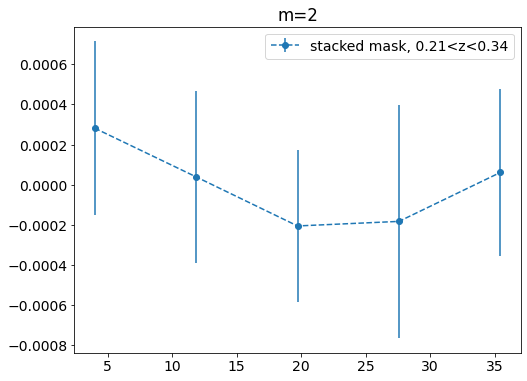

24 24


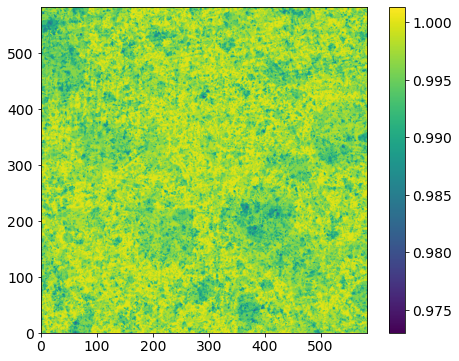

Number exceeding:  740


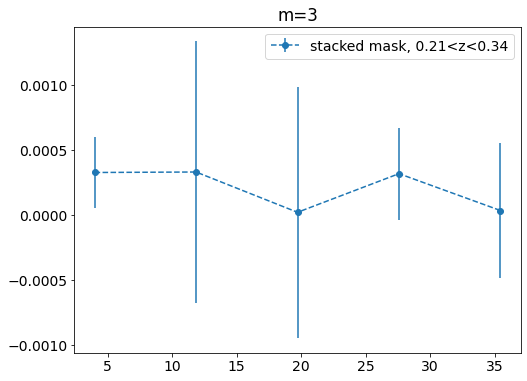

24 24


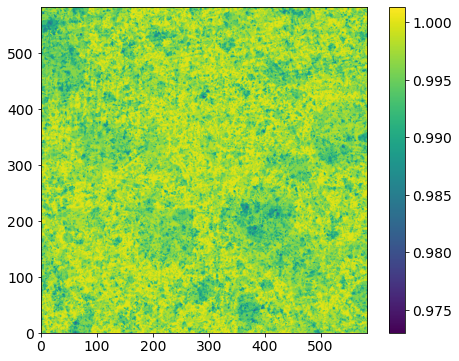

Number exceeding:  439


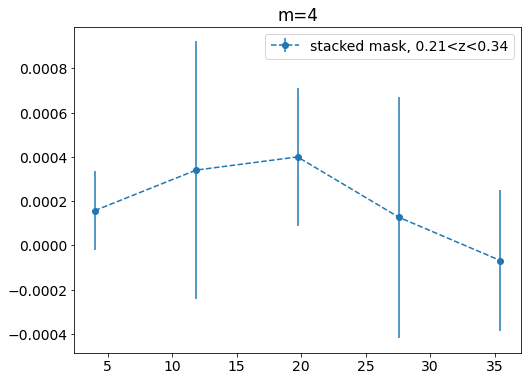

24 24


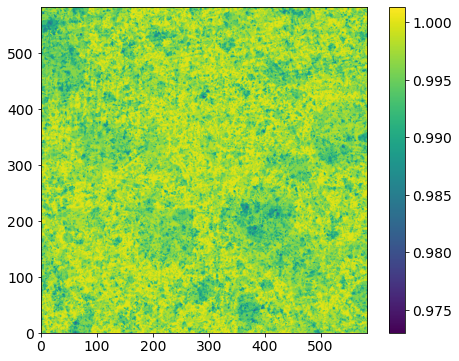

Number exceeding:  689


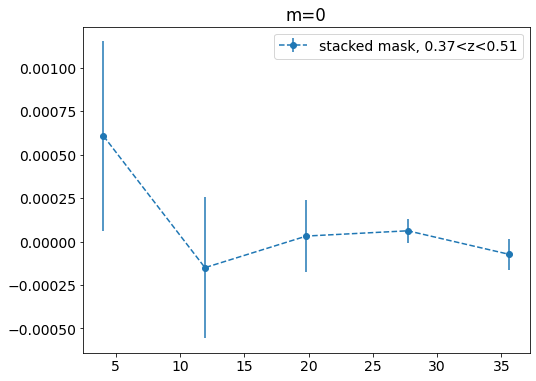

24 24


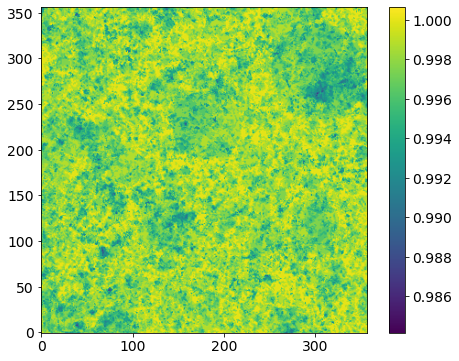

Number exceeding:  673


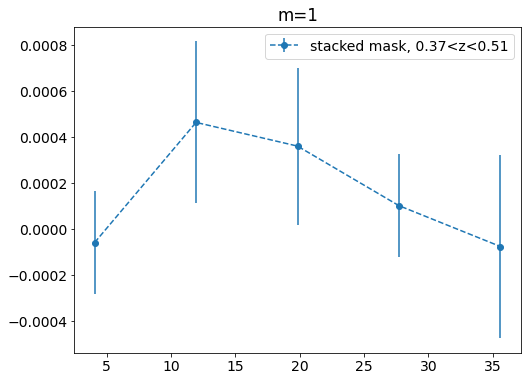

24 24


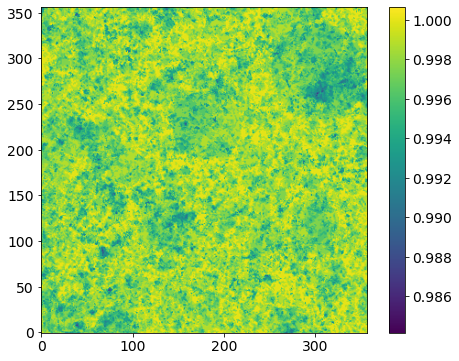

Number exceeding:  625


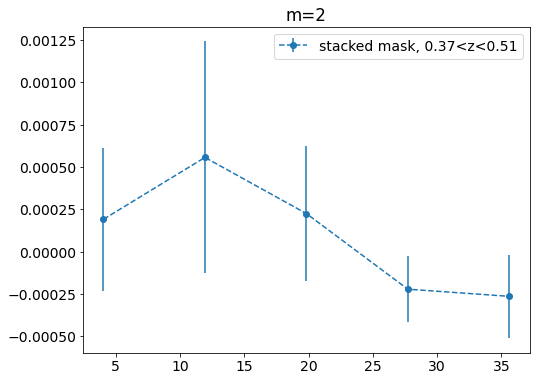

24 24


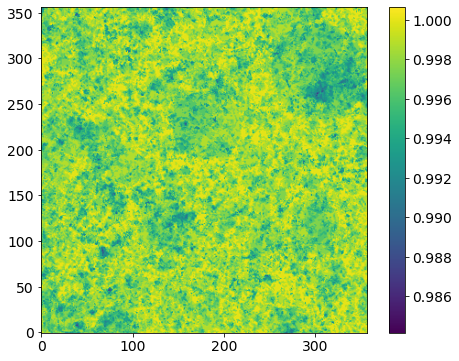

Number exceeding:  851


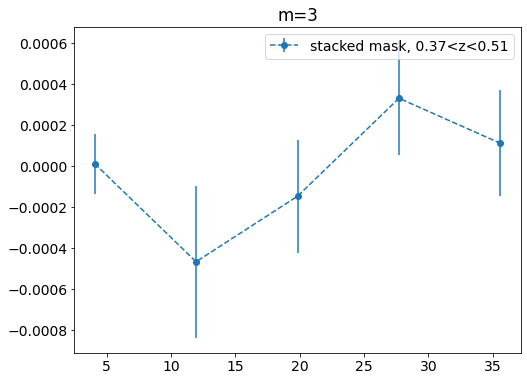

24 24


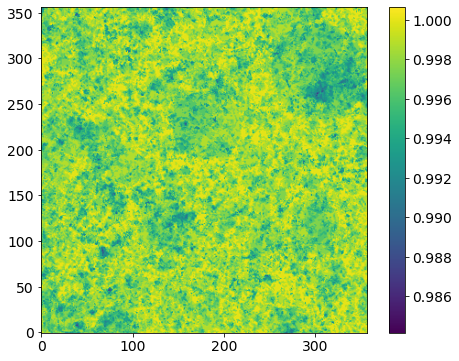

Number exceeding:  509


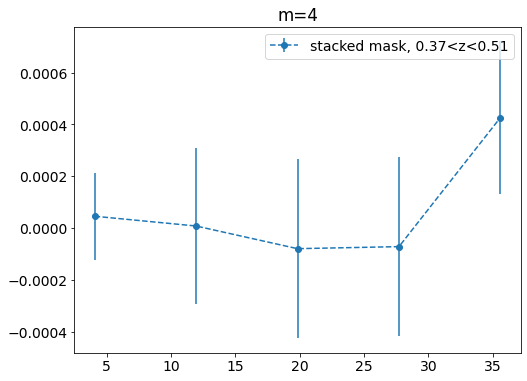

24 24


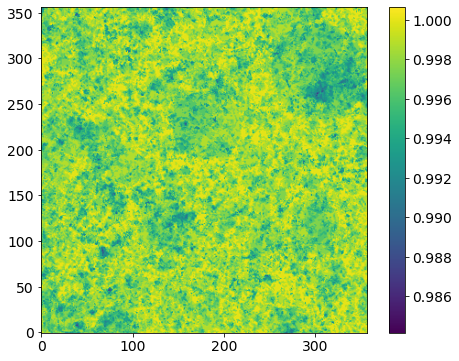

Number exceeding:  520


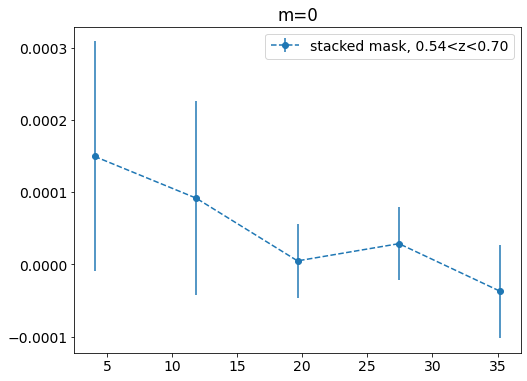

24 24


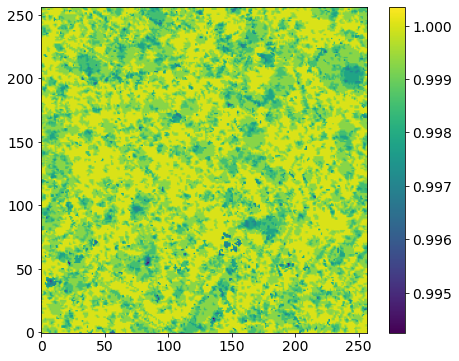

Number exceeding:  517


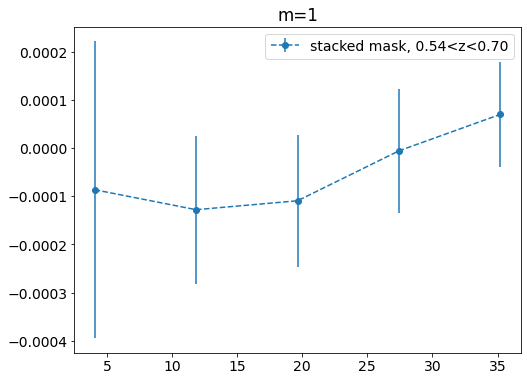

24 24


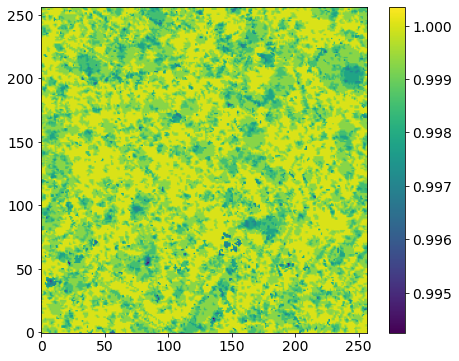

Number exceeding:  717


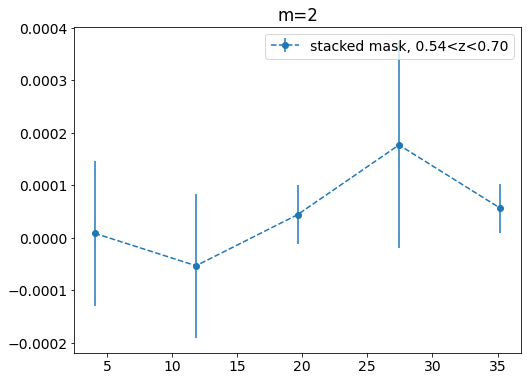

24 24


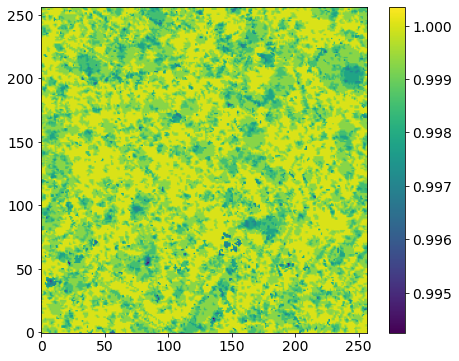

Number exceeding:  669


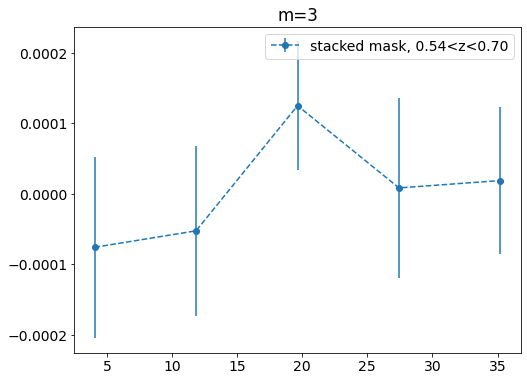

24 24


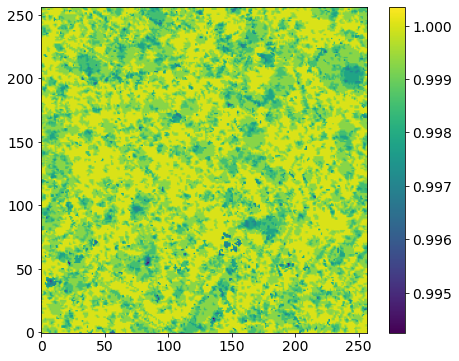

Number exceeding:  584


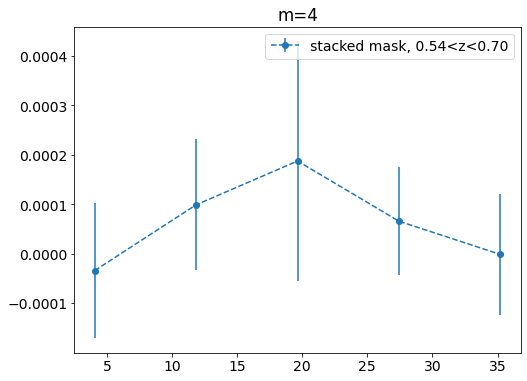

24 24


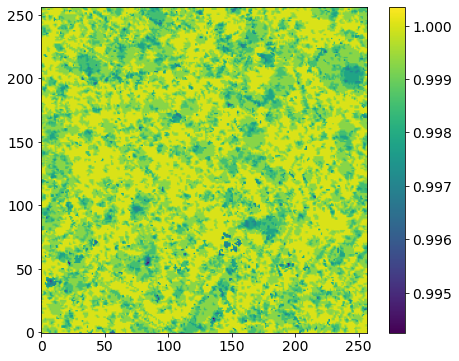

Number exceeding:  557


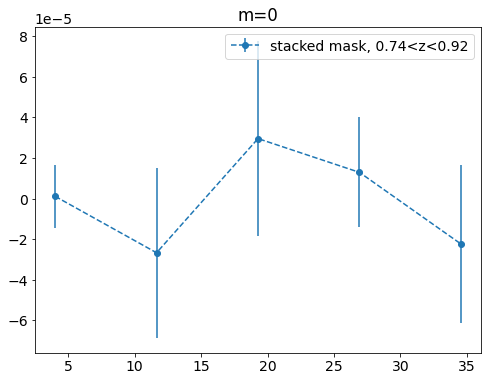

24 24


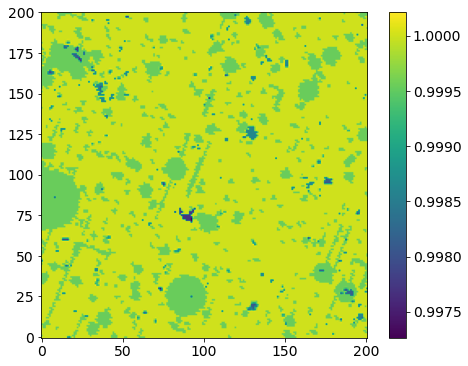

Number exceeding:  831


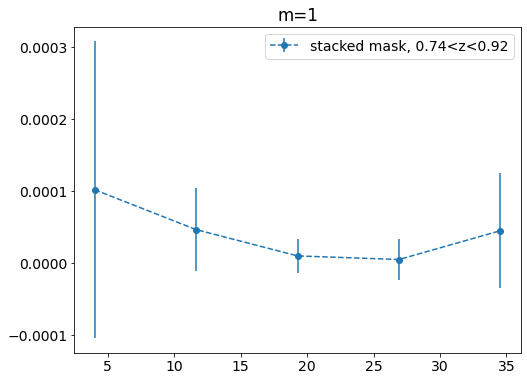

24 24


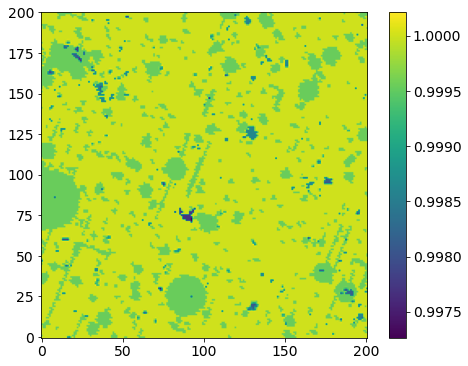

Number exceeding:  493


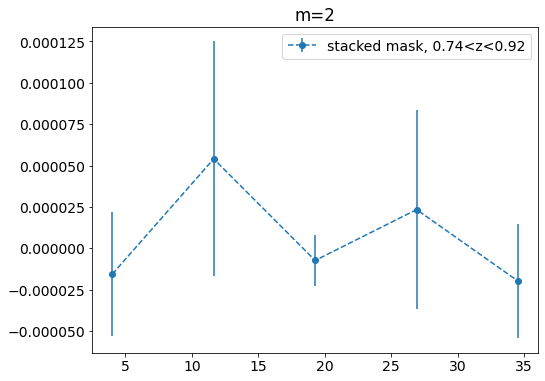

24 24


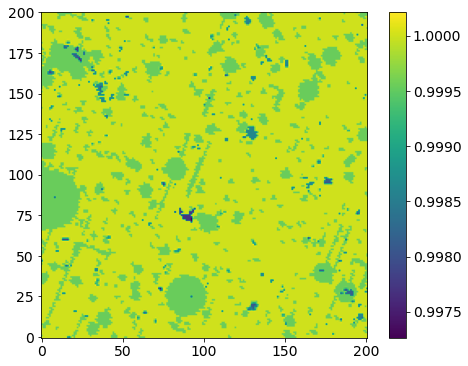

Number exceeding:  554


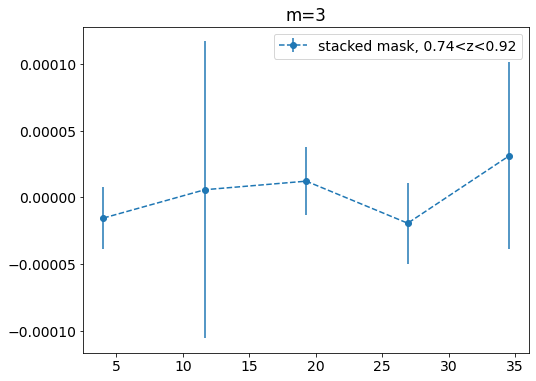

24 24


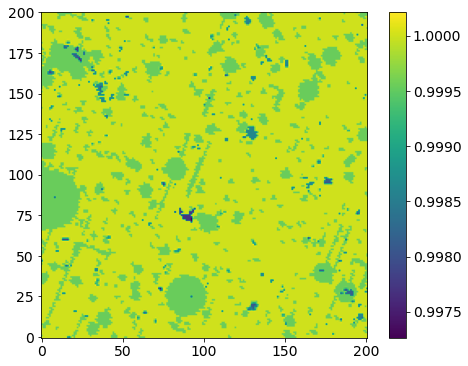

Number exceeding:  256


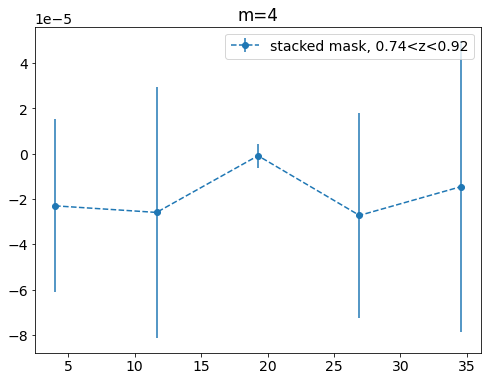

24 24


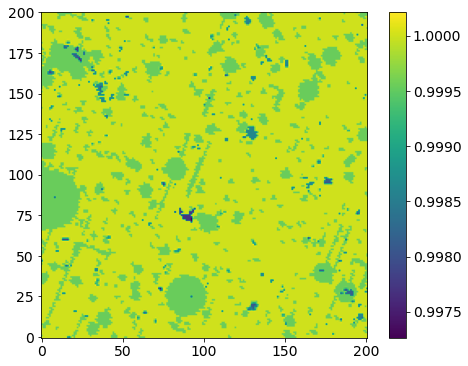

<Figure size 576x432 with 0 Axes>

In [35]:
profs_dbin = []
errors_dbin = []

masknull_snr = np.zeros((5,len(dbins)))
masknull_pte = np.zeros((5,len(dbins)))
for c, dbin in enumerate(dbins):

    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'DES_mask'
    maskfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_100pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    mskerrs   = np.load(maskfile, allow_pickle=True)
    profs = mskerrs['prof']
    mask = cpp.Stack_object(img_splits=mskerrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=mskerrs['npks_list'], rad_in_Mpc=mskerrs['rad_in_Mpc'][4].value)
    idx_r20 = np.where(np.abs(mask.r-20) == np.min(np.abs(mask.r-20)))[0][0]
    for r in range(mask.profile_splits.shape[1]):
        mask.profile_splits[0,r,:] -= np.average(mask.profile_splits[0,r,:][idx_r20:])
    mask.set_average_profiles()
    mask.bin_and_get_stats(8) #Mpc
    mlen = mask.profile_splits.shape[0]

    for m in range(mlen):
            null_vector = np.zeros(len(mask.avg_profiles_binned[m]))
            # print("Chi-squared of mask stack w.r.t. zero", st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])/(len(mask.avg_profiles[m])-1))
            pte, snr = st.snr_from_pte(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m], chisq_data=None)
            masknull_snr[m,c] = snr
            masknull_pte[m,c] = pte
    
            plt.errorbar(mask.r_binned, mask.avg_profiles_binned[m], yerr=mask.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
            plt.legend()
            plt.title("m={:d}".format(m))
            plt.show()
            plt.clf()
            
            
            print(len(mask.img_splits), mask.Nsamples)
            plt.imshow(mask.avg_img, origin='lower')
            plt.colorbar()
            plt.show()
            plt.clf()
    
    # print(mask.Npks_splits)
    # profs_dbin.append(mask.avg_profiles_binned[m])
    # errors_dbin.append(mask.errors_binned[m])


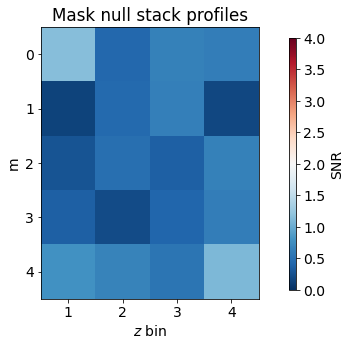

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax.imshow(masknull_snr, cmap='RdBu_r', vmin=0, vmax=4)
ax.set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax.set_xticks(np.arange(len(dbins)))
ax.set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax.set_xlabel(r"$z$ bin")
plt.title("Mask null stack profiles")
# add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
# centered title
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/snr_test_masknull.pdf", bbox_inches="tight")
plt.show()

In [20]:
mskerrs['rad_in_Mpc']

[<Quantity 40.18700642 Mpc>]

Number exceeding:  8


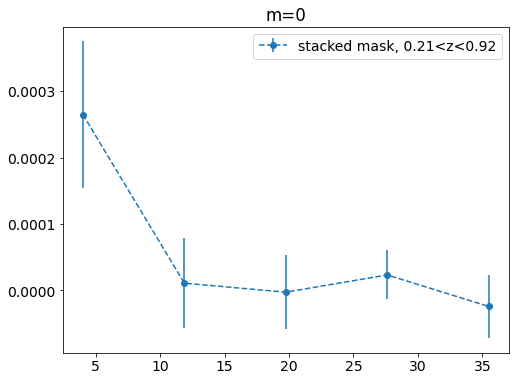

Number exceeding:  801


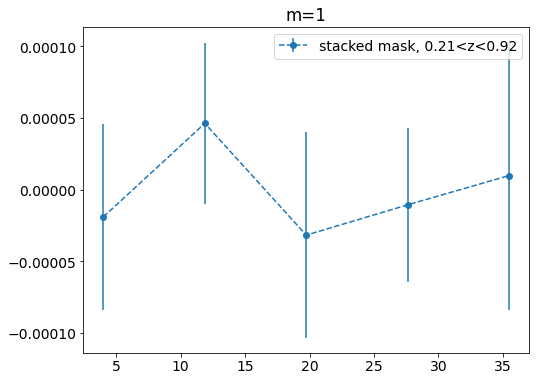

Number exceeding:  716


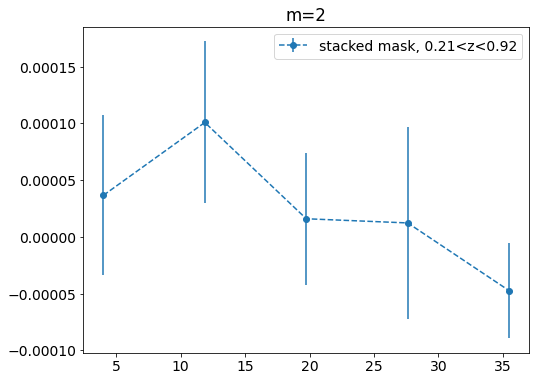

Number exceeding:  270


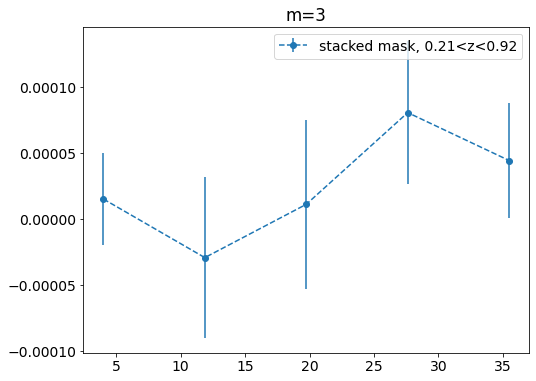

Number exceeding:  695


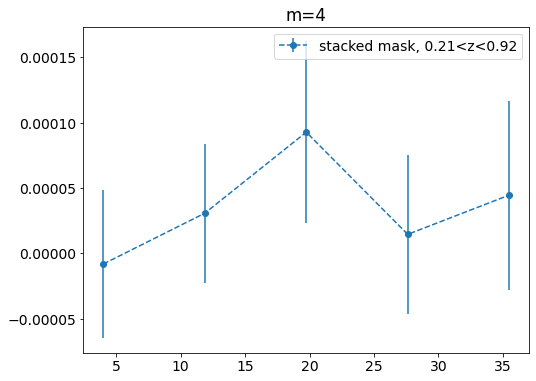

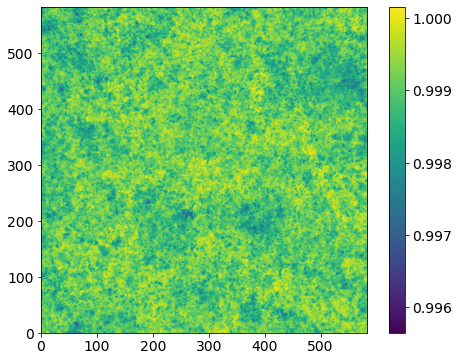

<Figure size 576x432 with 0 Axes>

In [31]:
profs_dbin = []
errors_dbin = []
zlow = z_at_value(cosmo.comoving_distance, 893*u.Mpc)
zhi = z_at_value(cosmo.comoving_distance, 3193*u.Mpc)
masknull_snr_tot = np.zeros((5,1))
masknull_pte_tot = np.zeros((5,1))
mapstr = f'DES_mask'
maskfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_893_3193Mpc_{:s}20pt0_orientXYUP_100pct_maglim_843_3243Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, pt_selection_str, nreg)
mskerrs   = np.load(maskfile, allow_pickle=True)
profs = mskerrs['prof'][0]
mask = cpp.Stack_object(img_splits=mskerrs['stacks'][0], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=mskerrs['npks_list'][0], rad_in_Mpc=mskerrs['rad_in_Mpc'][0].value)
idx_r20 = np.where(np.abs(mask.r-20) == np.min(np.abs(mask.r-20)))[0][0]
for r in range(mask.profile_splits.shape[1]):
    mask.profile_splits[0,r,:] -= np.average(mask.profile_splits[0,r,:][idx_r20:])
mask.set_average_profiles()
mask.bin_and_get_stats(8) #Mpc
mlen = mask.profile_splits.shape[0]

for m in range(mlen):
    null_vector = np.zeros(len(mask.avg_profiles_binned[m]))
    # print("Chi-squared of mask stack w.r.t. zero", st.chisq(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m])/(len(mask.avg_profiles[m])-1))
    pte, snr = st.snr_from_pte(mask.avg_profiles_binned[m], null_vector, mask.covmat_binned[m], chisq_data=None)
    masknull_snr_tot[m,0] = snr
    masknull_pte_tot[m,0] = pte

    plt.errorbar(mask.r_binned, mask.avg_profiles_binned[m], yerr=mask.errors_binned[m], fmt='o', linestyle='--', label='stacked mask, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.title("m={:d}".format(m))
    plt.show()
    plt.clf()
    
    

plt.imshow(mask.avg_img, origin='lower')
plt.colorbar()
plt.show()
plt.clf()

# print(mask.Npks_splits)
# profs_dbin.append(mask.avg_profiles_binned[m])
# errors_dbin.append(mask.errors_binned[m])



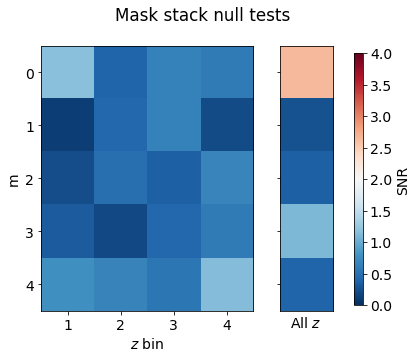

In [43]:
# set up figure with shared y and ratio 4 to 1
fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
# scmap = st.shiftedColorMap(plt.cm.RdBu_r, midpoint=2, name='shifted')
snr_plot = ax[0].imshow(masknull_snr, cmap='RdBu_r', vmin=0, vmax=4)
ax[0].set_ylabel("m")
# axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
# replace x ticks with r values
ax[0].set_xticks(np.arange(len(dbins)))
ax[0].set_xticklabels(["1", "2", "3", "4"])
# ax.set_xticklabels([f"{np.round(z_at_value(cosmo.comoving_distance, (dbin[0])*u.Mpc).value,2)} - {np.round(z_at_value(cosmo.comoving_distance, (dbin[1])*u.Mpc).value,2)}" for dbin in dbins], rotation=45)
ax[0].set_xlabel(r"$z$ bin")
# add an axis for a colorbar
# centered title
ax[1].imshow(masknull_snr_tot, cmap='RdBu_r', vmin=0, vmax=4)
ax[1].set_xlabel(r"All $z$")
ax[1].set_xticks([])
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(snr_plot, cax=cbar_ax, label="SNR")
plt.suptitle("Mask stack null tests")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/snr_test_masknull.pdf", bbox_inches="tight")
plt.show()


In [ ]:
for n, m in enumerate(mask.img_splits):
    plt.imshow(m, origin='lower', vmax=1.1, vmin=0.9)
    plt.colorbar()
    plt.show()
    plt.clf()
    print(np.sum(m)/np.size(m))
    print(mask.Npks_splits[n])
